In [1]:
import json
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import ast
from scipy.stats import ttest_ind

In [2]:
#jsonList = []
line_per_file = 15000
smallFile = None 
business ="./yelp_academic_dataset_business.json"

df_total = pd.DataFrame(columns = [])

In [3]:
#load the business data
def read_json(filename):
    jsonList = []
    df_total = pd.DataFrame()
    with open(filename,'r',encoding='utf8', errors='ignore') as f:
        for lineno, line in enumerate(f):
            jsonDict = json.loads(line)
            jsonList.append(jsonDict)
            for item in jsonList.copy():
                if (item.get('city') != 'Philadelphia' or item.get('attributes') == None or item.get('hours') == None):
                    jsonList.remove(item)
            if lineno % line_per_file == 0:
                data = pd.DataFrame.from_dict(jsonList, orient='columns')
                df_business = pd.DataFrame(data, columns = ['business_id','name','city', 'review_count', 'postal_code','stars','categories','attributes'])
                jsonList = []
                df_total = pd.concat([df_business,df_total])
    return df_total


In [4]:
df_business = read_json(business)

df_business.to_csv('business_final.csv', index = False)
df_business

KeyboardInterrupt: 

#### A1) Create a histogram of the 'review_count' attribute with 100 bins.

<AxesSubplot:xlabel='review_count', ylabel='Count'>

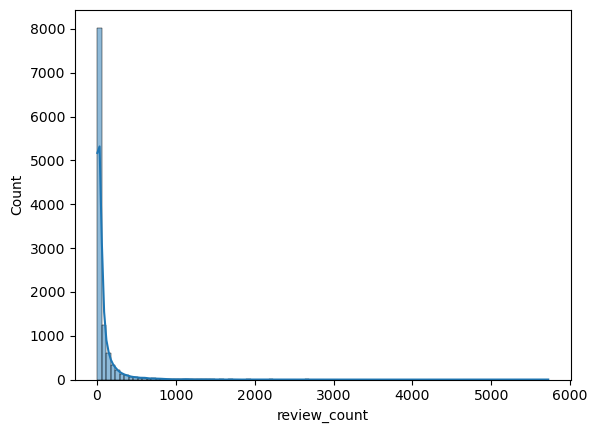

In [16]:
sns.histplot(df_business.review_count,bins=100,kde=True)

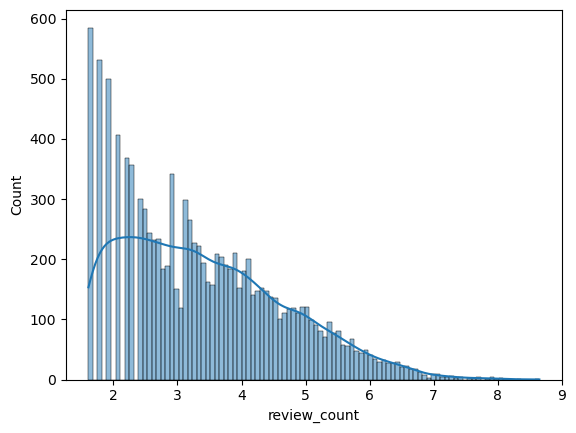

In [17]:
df_business_log = pd.DataFrame()
df_business_log["review_count"] = np.log(df_business["review_count"])
hist_log = sns.histplot(df_business_log.review_count,bins=100,kde=True)

In [18]:
df_business_log["Rank"] = df_business_log["review_count"].rank()
df_business_log["Rank"] = df_business_log["Rank"]/df_business_log["Rank"].max()
df_business_log.sort_values("Rank", inplace = True)


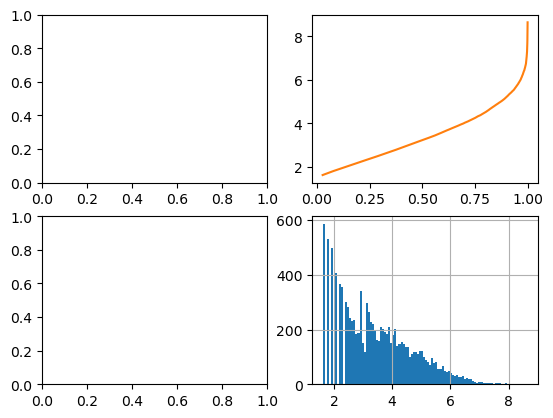

In [19]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2)
x = df_business_log["Rank"]
y = df_business_log["review_count"]

ax1 = df_business_log.review_count.hist(bins=100)
ax2.plot(x,y,'tab:orange')


In [20]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import norm
# import scipy.integrate as integrate
# range_100 = (df_business_log['review_count'].max() - df_business_log['review_count'].min())/100
# print(range_100)

# distribution_function = lambda x: norm.pdf(x, 0.1)

# x1 = df_business_log['review_count'].min()
# x2 = df_business_log['review_count'].max()

# print('probability to fall between {0} and {1} :'.format(x1, x2), integrate.quad(distribution_function, x1, x2)[0])
# step = 0.07042460981834428

# whole_x = np.arange(0, 10, step)
# whole_y = list(map(distribution_function, whole_x))

# needed_x = np.arange(x1, x2, step)
# needed_y = list(map(distribution_function, needed_x))
# print(needed_x)
# print(needed_y)
# plt.plot(whole_x, whole_y)
# plt.fill_between(needed_x, needed_y)

#### B Ερώτημα

In [11]:
def read_review(filename):
    df_reviews_total = pd.DataFrame()
    chunks = pd.read_json(filename, lines=True, chunksize = 10000)
    for chunk in chunks:
        df_reviews = pd.DataFrame(chunk, columns = ['user_id','review_id','business_id','stars','text'])
        df_reviews_total = pd.concat([df_reviews, df_reviews_total])
    print(df_reviews_total.head())
    return df_reviews_total

In [12]:
#print only four of the total colums because there was a memory limit
reviews = './yelp_academic_dataset_review.json'
df_review = read_review(reviews)
df_review.to_csv('review_final.csv', index = False)
display(df_review)

KeyboardInterrupt: 

In [ ]:
df_review['date'] = pd.to_datetime(df_review.date, format='%Y-%m-%d %H:%M:%S')
df_review['Month'] = df_review['date'].dt.strftime('%m')

df_month = df_review.groupby('business_id')['Month']

In [ ]:
df_review_grouped1 = df_review.groupby('business_id')['stars'].mean().reset_index(name='mean_stars')
display(df_review_grouped1)

In [ ]:
df_review_grouped = df_review.groupby(['business_id'])#group by bisiness_id with the min date
df_review_grouped2 = df_review_grouped.agg(Minimum_Date=('date',np.min))

df_review_grouped2 = df_review_grouped2.reset_index()
df_review_grouped2['day'] = pd.to_datetime(df_review.date, format='%Y-%m-%d %H:%M:%S')
df_review_grouped2['month'] = df_review_grouped2['day'].dt.strftime('%m')
#merge the dataframe of the mean rating per business_id with the dataframe of first review per business_id
df_review_grouped2 = pd.merge(df_review_grouped2,df_review_grouped1, on='business_id')
display(df_review_grouped2)

In [ ]:
sns.lineplot(x= 'month', y='mean_stars',data = df_review_grouped2)

#### Γ Ερωτημα: 
Συσχέτιση μεταξύ της αξίας της περιοχής και των επιχειρήσεων που βρίσκονται στην περιοχή αυτή. Η υπόθεση είναι ότι στις ακριβές περιοχές στεγάζονται και πολλές ή ακριβές επιχειρήσεις.

In [16]:
#Dataframe with the mean star rating for every zip_code
df_business1 = df_business.groupby('postal_code')['stars'].mean().reset_index(name='stars')

#read the tsv file and create a dataframe with columns like region and median_sale_price
df = pd.read_csv("RedfinPhila.tsv",sep='\t')
df = df[['region','median_sale_price']]
df= df.rename(columns = {'region':'postal_code'}) #rename the column to 'postal_code'

#calculate the dataframe with zip code and mean median sale price
df = df.groupby('postal_code')['median_sale_price'].mean().reset_index(name='mean_median_sale_price')
df = df.replace("Zip Code: ", "",regex=True)
df = pd.merge(df,df_business1, on='postal_code')

#count from the business dataframe the number of business
df_business_postal = df_business.groupby('postal_code')['business_id'].count().reset_index(name='num_of_Business')

#the Final Dataframe
df = pd.merge(df,df_business_postal, on='postal_code')
#df = df.groupby('postal_code')
display(df)



,postal_code,mean_median_sale_price,stars,num_of_Business
0,19003,348269.932594,4.000000,1
1,19010,469248.786871,4.500000,1
2,19014,207546.861213,3.500000,1
3,19023,80747.046260,2.000000,1
4,19102,596292.791304,3.677677,439
5,19103,671583.041111,3.819057,1039
6,19104,260677.601986,3.502564,585
7,19106,647241.991342,3.881289,636
8,19107,434303.716590,3.748279,1017
9,19110,334245.817460,4.000000,5


Στο παραπάνω dataframe απεικονίζεται για κάθε postal code η μέση τιμή της αξίας της περιοχης με το συγκεκριμένο postal code, η μέση τιμή της αξιολόγησης των επιχειρήσεων και ο αριθμός των επιχειρήσεων με το συγκεκριμένο postal code.

Επιπροσθέτως, το παρακάτω γράφημα ενσωματώνει όλα τα scatter plot των πεδίων ανα δύο.Με την χρήση των scatter plots, τα οποία χρησιμοποιούν σημεία για την αναπαρασταση της σχέσης μεταξύ δυο μεταβλητων, μπορούν να εξαχθούν τα τα εξής συμπεράσματα:

#### -->Scatter plot mean_median_price(άξονας x) και stars(άξονας y): 
Υπάρχει μια θετική συσχέτιση μεταξύ των δυο μεταβλήτων, καθώς όσο αυξάνεται το mean_median_price αυξάνεται και το stars μέχρι το τελευταίο να πάρει τιμές γύρω απο το 4, όπου τότε παρατηρείται μόνο η αύξηση του mean_median_price. Συγκεκριμένα, διαφαίνεται μια υσχυρή σχέση μεταξυ των δυο μεταβλητών για τιμές του mean_median_price στο διάστημα [(100000,250000] και για το stars στο διάστημα [3,4], καθώς η ομαδοποίηση ειναι πολύ στενη. Επομένως, επιχειρήσεις με μέτρια βαθμολογία στεγάζονται σε σχετικά πιο φθηνές περιοχές, ενώ επιχειρήσεις με βαθμολογία γύρω απο το 4, στεγάζονται σε περιοχές με ένα διάστημα αξίας από [250000, 500000]. Ελάχιστες επιχειρήσεις με βαθμολογία γύρω απο το 4 βρίσκονται σε πολυ ακριβές περιοχές.

#### -->Scatter plot mean_median_price(άξονας x) και num_of_Business(άξονας y): 
Στο συγκεκριμένο scatter plot, διαφαίνεται ότι στις φθηνές περιοχές [100000,200000] βρίσκεται μικρός αριθμός επιχειρήσεων σε σχέση με περιοχές με αξία πανω απο 200.000. Όσο αυξάνεται η αξία της περιοχής τόσο φαινεται να αυξάνεται και ο αριθμός των επιχειρήσεων στην περιοχή αυτή. Υπάρχει μια θετική συσχέτηση μεταξύ των δυο μεταβλήτων όμως υπαρχουν και outliers. Υπάρχουν outliers τα οποία είναι ασυνήθιστα, όπως τα σημεία x1 = (1039,671583), 
x2 = (1017,434303), τα οποία απέχουν μεγάλη απόσταση από τα υπολοιπα, αλλα και σημεία τα οποία μπορεί να μην απεχουν μεγαλη αποσταση απο τα υπολοιπα σημεία, αλλά δεν κάνουν τόσο καλό fit στην σχέση μεταξύ των δύο μεταβλήτων που περιγραφηκε νωρίτερα, οπως το σημείο x =(1,469248)

#### -->Scatter plot stars(άξονας x) και num_of_Business(άξονας y): 
Απο το συγκεκριμένο γράφημα, παρατηρείται ότι όσο αυξάνεται ο αριθμός επιχειρήσεων ανα περιοχή, τόσο πιο μεγάλη είναι και η βαθμολογία. Πιο συγκεκίμενα για πλήθος επιχειρήσεων απο [0,100], η βαθμολογία κυμένεται από [3,4] (περίπου), όπως επισης και  για πλήθος επιχειρήσεων απο [100,300] . Με την αύξηση του πλήθους των επιχειρήσεων,η βαθμολογια αυξάνεται ελάχιστα και ύστερα διατηρείται σταθερή. Απο το συγκεκριμένο γράφημα δεν μπόρει να εξαχθεί κάποιο απόλυτο συμπέρασμα για την υπόθεση που έχει τεθεί, καθώς η συσχέτηση είναι αρκετά μικρή

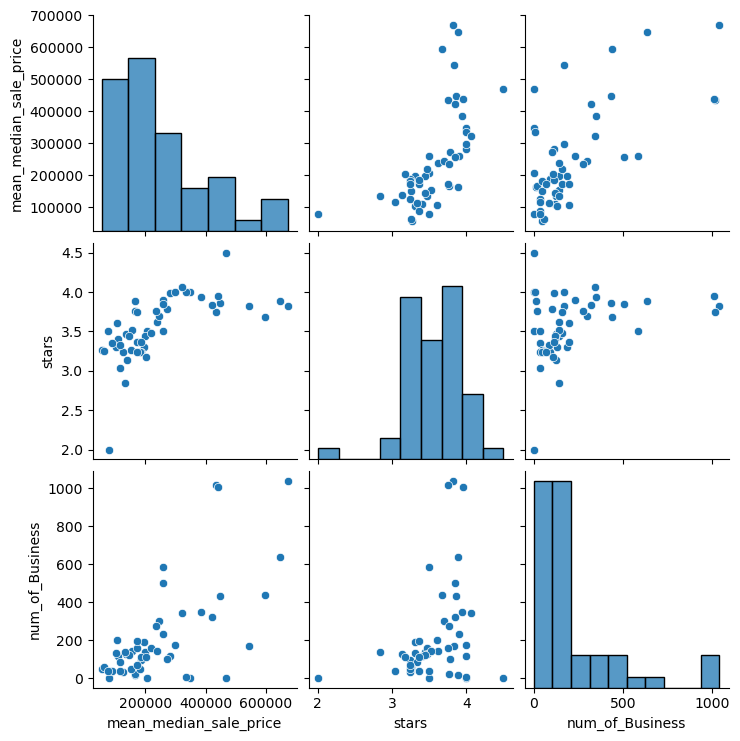

In [17]:
sns.pairplot(df)

#### Παρακάτω αναπαρίσταται το heatmap των correlation των μεταβλητών.

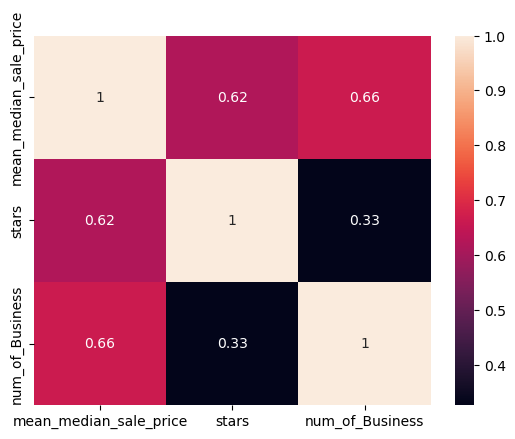

In [18]:
_ = sns.heatmap(df.corr(), annot=True)

Υπόθεση: Σε ακριβές περιοχές υπάρχουν καλές επιχειρήσεις.
Υπολογίζοντας τα correlation και τα p-values ανα δύο των μεταβλητών mean_median_sale_price, stars, num_of_Business, τα παραπάνω συμπεράσματα απο τα scatter plots βγαίνουν αληθή. Πιο συγκεκριμένα, για το ζεύγος mean_median_sale_price - stars το correlation είναι ισχυρό(0.61978) και θετικό, καθώς και το p-value είναι πολύ μικρό(9.612180731159571e-07). Όσο πιο μικρό ειναι το p-value(πιθανότητα), τόσο πιο έντονα τα δεδομένα απορρίπτουν το null hypothesis. 

Υπόθεση: Σε ακριβές περιοχές υπάρχουν πολλές επιχειρήσεις.
Το ίδιο ισχυει και για το ζεύγος (mean_median_sale_price,num_of_Business) με correlation = 0.663458 και p-value = 8.311491123956479e-08, τιμές οι οποίες δηλώνουν εντονότερα την στατιστική σημασία. 

Τέλος, για το τρίτο ζεύγος stars - num_of_business το correlation είναι ίσο με 0.3262747 με p-value=0.01824500702911858. Με βάση τα παραπάνω αποτελέσματα και το ποσο μικρά υπολογίστηκαν τα δύο προηγούμενα p-values, αλλά και το πόσο κοντά είναι η τιμή του correlation στο 0(χαμήλη θετική συσχέτηση), αν θεωρηθεί ώς όριο για το p-value η τιμή 0.05( αν η τίμη μικρότερη απο 0.05, τότε απορρίπτεται το null hypothesis), υπάρχει μια υποτιπώδης συσχέτιση μεταξύ των δύο μεταβλητών, δηλαδή όχι και τόσο στατιστικά σημαντική. 



In [19]:
print("Correlation and p-value between mean_median_sale_price - stars ")
print(stats.pearsonr(df.mean_median_sale_price,df.stars)) #mean_median_sale_price - stars
print(" ")
print("Correlation and p-value between mean_median_sale_price - num_of_business ")
print(stats.pearsonr(df.mean_median_sale_price,df.num_of_Business)) #mean_median_sale_price - num_of_Business
print(" ")
print("Correlation and p-value between stars - num_of_business ")
print(stats.pearsonr(df.stars,df.num_of_Business)) #stars - num_of_Business

Correlation and p-value between mean_median_sale_price - stars 
PearsonRResult(statistic=0.6197790452303014, pvalue=9.612180731159571e-07)
 
Correlation and p-value between mean_median_sale_price - num_of_business 
PearsonRResult(statistic=0.6634582974013836, pvalue=8.311491123956479e-08)
 
Correlation and p-value between stars - num_of_business 
PearsonRResult(statistic=0.326274653238417, pvalue=0.01824500702911858)


#### Τα p-values των μεταβλητών ανα δύο

In [20]:
p_df = pd.DataFrame(columns=['mean_median_sale_price','stars', 'num_of_Business'])
for col in df:
    for col1 in df:
        if (pd.api.types.is_numeric_dtype(df[col]) and pd.api.types.is_numeric_dtype(df[col1])):
            r,p = stats.pearsonr(df[col],df[col1])
            p_df.loc[col,col1] = [p]
p_df

,mean_median_sale_price,stars,num_of_Business
mean_median_sale_price,[0.0],[9.612180731159571e-07],[8.311491123956479e-08]
stars,[9.612180731159571e-07],[0.0],[0.01824500702911858]
num_of_Business,[8.311491123956479e-08],[0.01824500702911858],[0.0]


#### Παρατήρηση συσχετήσεων, αν αφαιρεθούν περιοχές αξίας μικρότερης του 200000

In [21]:
#drop rows which have mean_median_sale_price over than 200.000
df_expensive_regions = df[df.mean_median_sale_price > 200000]
display(df_expensive_regions)
#df_expensive_regions


,postal_code,mean_median_sale_price,stars,num_of_Business
0,19003,348269.932594,4.000000,1
1,19010,469248.786871,4.500000,1
2,19014,207546.861213,3.500000,1
4,19102,596292.791304,3.677677,439
5,19103,671583.041111,3.819057,1039
6,19104,260677.601986,3.502564,585
7,19106,647241.991342,3.881289,636
8,19107,434303.716590,3.748279,1017
9,19110,334245.817460,4.000000,5
13,19115,219089.412844,3.474522,157


Scatter-plot mean_median_sale_price - stars: Παρατηρείται μια μικρή αύξηση

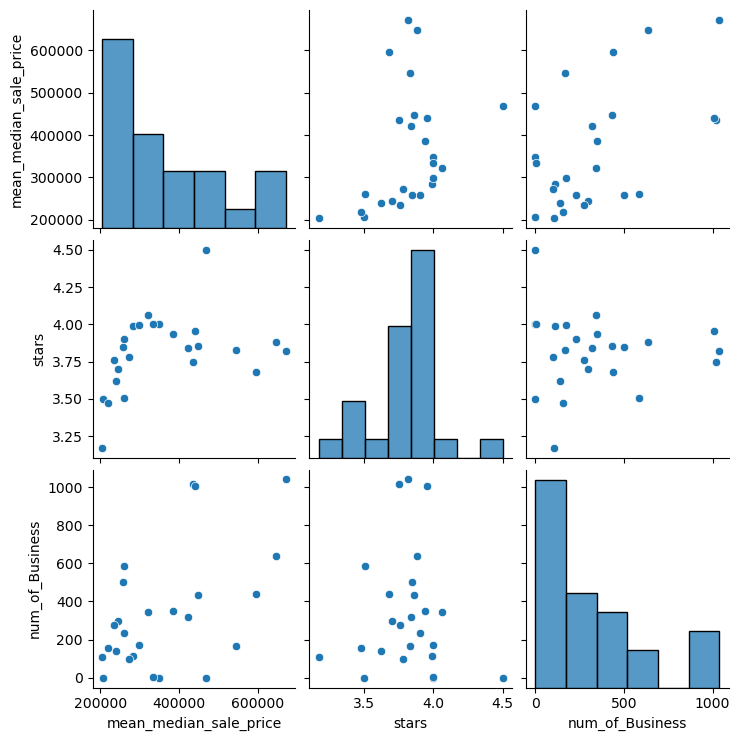

In [22]:
sns.pairplot(df_expensive_regions)

--> Correlation, p-value για mean_median_sale_price - stars: Με την αφαίρεση των περιοχών αξίας μικρότερης του 200000, παρατηρείται ότι η τιμη του Correlation μεταξύ των δύο μεταβλητών έχει μικρύνει και το p-value έχει γίνει αρκετά μεγάλο(>0.05) με αποτέλεσμα να μην υπάρχει στατιστική σημαντικότητα και να μην απορρίπτεται το null hupothesis και άρα μην ισχύει η υπόθεση ότι στις ακριβές περιοχές βρίσκονται και καλές επιχειρήσεις.

--> Correlation, p-value για mean_median_sale_price - num_of_Business: Στο συγκεκριμένο ζεύγος η στατιστική σημαντικότητα παραμενει σαν συμπερασμα, καθώς το correlation μειώθηκε ελάχιστα και το p-value παραμένει μικρότερο του 0.05 (0.00714489).
Επομένως, η αρχική υπόθεση ότι στις καλές περιοχές υπάρχουν πολλες επιχειρήσεις μπορεί να σταθεί λογικά.

--> Correlation, p-value για stars - num_of_Business: Όπως φαίνεται και στο scatter plot και με βάση την τιμή του correlation, η οποία είναι -0.04 , τιμή πολύ κοντά στο 0, καθώς και την τιμη του p-value,τιμή πολύ μεγάλη(0.85077), συμπεραίνεται  το ότιδ εν υπάρχει correlation μεταξύ των δύο μεταβλητών. 

Το heatpmap των correlations για περιοχές αξίας πάνω των 200000

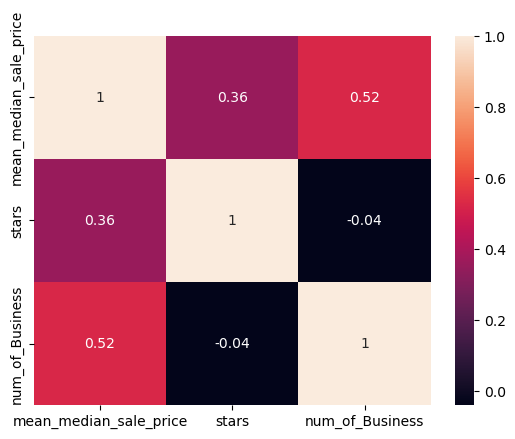

In [23]:
_ = sns.heatmap(df_expensive_regions.corr(), annot=True)

In [24]:
df_expensive_regions_p = pd.DataFrame(columns=['mean_median_sale_price','stars', 'num_of_Business'])
for col in df_expensive_regions:
    for col1 in df_expensive_regions:
        if (pd.api.types.is_numeric_dtype(df_expensive_regions[col]) and pd.api.types.is_numeric_dtype(df_expensive_regions[col1])):
            r1,p1 = stats.pearsonr(df_expensive_regions[col],df_expensive_regions[col1])
            df_expensive_regions_p.loc[col,col1] = [p1]
display(df_expensive_regions_p)


,mean_median_sale_price,stars,num_of_Business
mean_median_sale_price,[0.0],[0.08004458459309063],[0.007144877997834159]
stars,[0.08004458459309063],[1.5864253030664577e-181],[0.8507696932414337]
num_of_Business,[0.007144877997834159],[0.8507696932414337],[4.5947784791827063e-178]


### Δ Ερώτημα: 
Μελέτη της διαφοράς μεταξύ των βαθμολογιών διαφορετικών επιχειρήσεων 

In [25]:
df_restaurants = df_business[df_business['categories'].str.contains("Restaurants")==True]
def create_dataframes_price_range(dataframe):
    restaurants = pd.DataFrame()
    data = {}
    keys_data = ["business_id","stars","RestaurantsPriceRange2","label_priceRange"]
    for id_b,dict1,stars in zip(dataframe.business_id,dataframe.attributes,df_restaurants.stars):
        key = 'RestaurantsPriceRange2'
        if key in dict1.keys():
            if(dict1['RestaurantsPriceRange2'] == "1" or dict1['RestaurantsPriceRange2'] == "2"):
                values_data = [id_b,stars,dict1['RestaurantsPriceRange2'],"cheap"]
            else:
                values_data = [id_b,stars,dict1['RestaurantsPriceRange2'],"expensive"]
            for i in range(len(keys_data)):
                data[keys_data[i]] = values_data[i]
            df = pd.DataFrame([data])
            restaurants = pd.concat([restaurants,df], ignore_index = True)
    return restaurants

restaurants = create_dataframes_price_range(df_restaurants)
display(restaurants)

,business_id,stars,RestaurantsPriceRange2,label_priceRange
0,ghFNIv9_Bde6uquScRZD7g,4.0,2,cheap
1,e8jerbHMWQ1JSYxKtXEt5w,2.0,1,cheap
2,zpKTPWoW56wF6d9qNnxM3Q,4.0,1,cheap
3,UzU1N9XSoAUwn4Z8BIcvKw,4.0,2,cheap
4,KnPLPaIimYCzGu4Qxli2DA,3.5,1,cheap
...,...,...,...,...
4109,s3Q1J4XEVOBiZy9dYUpqpg,3.5,2,cheap
4110,3lBooCffgkW7tVSG5kILBA,3.5,2,cheap
4111,uIZwBkvWicqyWraXvYOipw,4.0,3,expensive
4112,krTHKI0YOpASr4gz2CVWFw,2.5,1,cheap


In [26]:
#sns.pointplot(data = df_cheap_expensive,x = "label_priceRange", y = "mean_stars")

Στο παρακάτω pointplot φαίνεται ότι η μέση τιμή της βαθμολογίας για φθηνά εστιατόρια είναι 3.540666, ενώ τα error bars είναι αρκετα μικρά, το οποίο σημαίνει ότι υπαρχει μικρή αβεβαιότητα γύρω απο την συγκεκριμένη μεταβλητή.

Αντιστοιχα, η μέση τιμή της βαθμολογίας για ακριβά εστιατόρια είναι 3.798755, ενώ τα error bars είναι μεγαλύτερα απο τα error bars των φθηνών εστιατορίων με αποτέλεσμα να φανερώνεται μεγαλύτερη αβεβαιότητα γύρω απο την βαθμολογια των ακριβών εστιατορίων.

<AxesSubplot:xlabel='label_priceRange', ylabel='stars'>

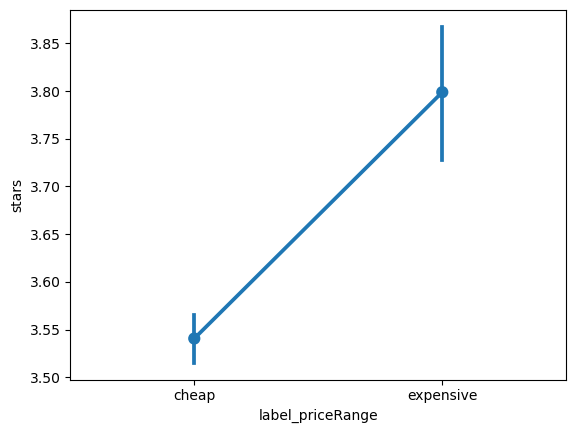

In [27]:
sns.pointplot(data = restaurants,x = "label_priceRange", y = "stars")

Απο το παρακάτω Student t-test προκύπτει το συμπέρασμα ότι η διαφορά της μέσης βαθμολογίας ανάμεσα στους δύο τύπους εστιατορίων είναι αρκετά σημαντική, καθώς το p-value ειναι μικρότερο απο 0.05.
(Είναι σημαντικό κατά το τεστ να βάλουμε ως παράμετρο το equal_var = False, ώστε να μην γίνει η υπόθεση ίσης διακύμανσης του πλυθησμού, καθώς τότε θα είναι διαφορετικό το αποτέλεσμα του p-value)

In [28]:
#t-test price Range

group_cheap = restaurants[restaurants['label_priceRange'] == 'cheap']
group_expensive = restaurants[restaurants['label_priceRange'] == 'expensive']
print(stats.ttest_ind(group_cheap['stars'],group_expensive['stars'],equal_var = False))

Ttest_indResult(statistic=-6.507738258428972, pvalue=3.264781509669584e-10)


Μελέτη της διαφοράς μεταξύ των βαθμολογιών διαφορετικών επιχειρήσεων αναλογα με την ενδυμασία.

In [29]:
def create_dataframes_attire(dataframe):
    restaurants_attire = pd.DataFrame()
    data = {}
    keys_data = ["business_id","stars","RestaurantsAttire","label_Attire"]
    for id_b,dict1,stars in zip(dataframe.business_id,dataframe.attributes,df_restaurants.stars):
        key = 'RestaurantsAttire'
        if key in dict1.keys():
            if(dict1['RestaurantsAttire'] == "u'casual'" or dict1['RestaurantsAttire'] == "casual"):
                values_data = [id_b,stars,dict1['RestaurantsAttire'],"casual"]
            else:
                 values_data = [id_b,stars,dict1['RestaurantsAttire'],"formal"]
            for i in range(len(keys_data)):
                data[keys_data[i]] = values_data[i]
            df = pd.DataFrame([data])
            restaurants_attire = pd.concat([restaurants_attire,df], ignore_index = True)
    return restaurants_attire

restaurants_attire = create_dataframes_attire(df_restaurants)
print(restaurants_attire)


                 business_id  stars RestaurantsAttire label_Attire
0     ghFNIv9_Bde6uquScRZD7g    4.0         u'casual'       casual
1     zpKTPWoW56wF6d9qNnxM3Q    4.0         u'casual'       casual
2     UzU1N9XSoAUwn4Z8BIcvKw    4.0         u'casual'       casual
3     Rbe567WR_gpGMHvimhLLSQ    3.0          'casual'       formal
4     03K9F1xumPgdRiohRrXyfw    3.0         u'casual'       casual
...                      ...    ...               ...          ...
3599  -CRjqZ4GxZ6lIa_qMj7-yw    3.5         u'casual'       casual
3600  3lBooCffgkW7tVSG5kILBA    3.5          'casual'       formal
3601  uIZwBkvWicqyWraXvYOipw    4.0         u'dressy'       formal
3602  krTHKI0YOpASr4gz2CVWFw    2.5         u'casual'       casual
3603  cYU-9JM4x4ra-aCxbgtxfg    3.5         u'casual'       casual

[3604 rows x 4 columns]


Στο παρακάτω pointplot φαίνεται ότι η μέση τιμή της βαθμολογίας για εστιατόρια με casual ενδυμασία είναι 3.59, με τα  error bars είναι αρκετα μεγαλα, το οποίο σημαίνει ότι υπαρχει μεγάλη αβεβαιότητα γύρω απο την συγκεκριμένη μεταβλητή.

Αντιστοιχα, η μέση τιμή της βαθμολογίας για εστιατόρια με formal ενδυμασία είναι 3.53, με τα error bars να είναι επίσης μεγάλα  με αποτέλεσμα να φανερώνεται μεγάλη αβεβαιότητα γύρω απο την βαθμολογια των εστιατορίωνμε επίσημη βαθμολογία.


<AxesSubplot:xlabel='label_Attire', ylabel='stars'>

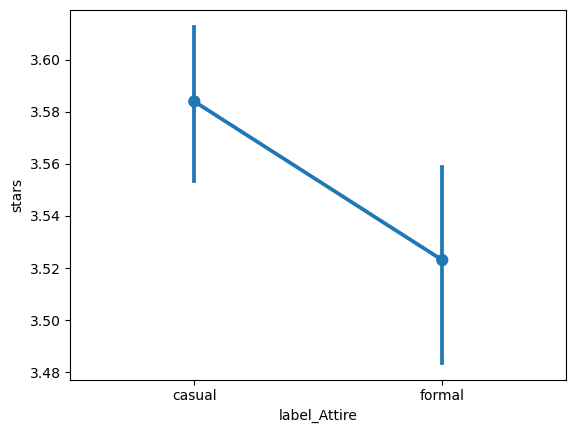

In [30]:
sns.pointplot(data = restaurants_attire,x = "label_Attire", y = "stars")

Απο το παρακάτω Student t-test προκύπτει το συμπέρασμα ότι η διαφορά της μέσης βαθμολογίας ανάμεσα στους δύο τύπους εστιατορίων είναι σημαντική, καθώς το p-value ειναι μικρότερο απο 0.05. Eπομένως, απορρίπτεται το null hypothesis, ότι δηλαδη δεν μπορεί να γίνει διάκριση των εστιατορίων με βάση τον κανονισμό για την ενδυμασία.

In [31]:
group_casual = restaurants_attire[restaurants_attire['label_Attire'] == 'casual']
group_formal = restaurants_attire[restaurants_attire['label_Attire'] == 'formal']
print(stats.ttest_ind(group_casual['stars'],group_formal['stars'],equal_var = False))

Ttest_indResult(statistic=2.439464750920493, pvalue=0.014762974266976502)


### Ε Ερώτημα

In [32]:
def attire(dataframe):
    values_data = []
    restaurants_ambience = pd.DataFrame()
    for b_id,attributes in zip(dataframe.business_id,dataframe.attributes):
        data = {}
        new_data = {}
        columns_name = ["business_id", "romantic","classy"]
        keys_ambience = ["romantic","intimate","classy","upscale"]
        for key, value in attributes.copy().items():
            if(value == "None"):
                del attributes[key]
        for ambience, value in list(attributes.items()):
            if(ambience == "Ambience"):
                ambience_dict = ast.literal_eval(attributes[ambience]) #convert the string to dictionary
                for k, value in ambience_dict.copy().items():
                    if k in keys_ambience:
                        new_data[k] = value
                        up = "upscale"    
                        if((up in  ambience_dict.keys()) != True):
                            new_data[up] = False 
                ambience_dict = new_data
                #print(b_id,ambience_dict)
                             
                if(ambience_dict["romantic"] == True or ambience_dict["intimate"] == True):
                    values_data = [b_id, True]
                else:
                    values_data = [b_id, False]
                if(ambience_dict["classy"] == True or ambience_dict["upscale"] == True):
                    values_data.append(True)
                else:
                    values_data.append(False)

        #print(values_data)

        for d in range(len(columns_name)):
            data[columns_name[d]] = values_data[d]
            df = pd.DataFrame([data])
            restaurants_ambience = pd.concat([restaurants_ambience,df], ignore_index = True)
    return restaurants_ambience
    #print(attributes)

In [33]:
restaurants_ambience = attire(df_restaurants)
restaurants_ambience = restaurants_ambience.dropna(subset=restaurants_ambience.columns.values)
restaurants_ambience
df.dropna(subset=df.columns.values)
restaurants_ambience

,business_id,romantic,classy
2,ghFNIv9_Bde6uquScRZD7g,False,False
5,e8jerbHMWQ1JSYxKtXEt5w,False,False
8,zpKTPWoW56wF6d9qNnxM3Q,False,False
11,UzU1N9XSoAUwn4Z8BIcvKw,False,False
14,WAWI8FB77nZVD7_yc2PMYw,False,False
...,...,...,...
14441,s3Q1J4XEVOBiZy9dYUpqpg,False,False
14444,3lBooCffgkW7tVSG5kILBA,True,True
14447,uIZwBkvWicqyWraXvYOipw,False,True
14450,krTHKI0YOpASr4gz2CVWFw,False,False


In [34]:
#create contingency table
ct = pd.crosstab(index=restaurants_ambience['classy'], columns=restaurants_ambience['romantic'])
chi_square = stats.chi2_contingency(ct)
display(ct)
display(chi_square)

romantic,False,True
classy,,
False,3742,124
True,824,128


(159.47123221738588,
 1.4763145068441628e-36,
 1,
 array([[3663.79327522,  202.20672478],
        [ 902.20672478,   49.79327522]]))

Το Chi-square test αποφασίζει πότε υπάρχει σχέση στατιστικής σημαντικότητας ανάμεσα σε categorical variables. Είναι ένα hypothesis test το οποίο απαντά στην ερώτηση-πότε οι τιμές μιας categorical variable εξαρτόνται απο τις τιμές μιας άλλης categorical variable. To test συγκρίνει τις παρατηρούμενες συχνότητες με τις συχνότητες που αναμένονται, αν οι δυο μεταβλήτες δεν σχετίζονται. Όταν οι μεταβλήτες δεν σχετίζονται, οι δυο παραπάνω συχνότητες θα είναι όμοιες.

Για να υπολογιστεί όμως το Chi-square test πρέπει πρώτα να οργανωθούν τα δεδομένα σε έναν contingency table. Ο συγκεκριμένος πίνακας εμφανίζει συχνότητες, οι οποίες αναφέρονται πάνω στους συνδιασμούς των δύο κατηγορικών μεταβλήτών, δηλαδή οι συχνότητες που έχουν παρατηρηθεί. Από τον συγκεκριμένο πίνακα, μπορεί πολύ εύκολα να υπολογιστούν και οι συχνότητες που αναμένονται. Πιο συγκεκριμένα, για τον κάθε συνδιασμό αθροίζεται το συνολίκο άθροισμα της συγκεκριμένης γραμμής με το συνολικο άθροισμα της συγκεκριμένης στήλης και στη συνέχεια διαιρείται με τον πληθυσμο. Για παράδειγμα, η αναμένομενη συχνότητα για "romantic" = False, "classy" = False είναι, (3.742 + 124) + (3.742 + 824)/ 4818  = 3663.79327522.

Η πρώτη τιμή(159.47123221738588) είναι η Chi-square τιμή, η οποία ακολουθείται απο την p-value(1.4763145068441628e-36). Η τρίτη τιμή είναι ο βαθμός ελευθερίας, ο οποίος υπολογίζεται ως εξής, αφού υπάρχουν 2 κατηγορίες(romantic, classy) και δύο έξοδοι (Τrue, False), τότε (2-1)*(2-1) = 1 βαθμός ελευθερίας.Συνήθως, το significance level είναι 0.05. Από τα παραπάνω, υπολογίζεται το critical value το οποίο ε΄ίναι 3.84. 

Παρατηρείται ότι το αποτέλεσμα του Chi-square είναι μεγαλύτερο απο το critical value και το p-value < 0.05. Επομένως, η διαφορά ανάμεσα σε παρατηρούμενες και αναμενόμενες κατανομές ειναι στατιστικά σημαντική και ετσι απορρίπτεται η null Hypothesis(null Hypothesis: Δεν υπάρχουν σχέσεις ανάμεσα στις categorical variables. Αν είναι γνωστή η τιμή της μίας μεταβλήτης, η γνώση αυτή καθίσταται άχρηστη για την πρόβλεψη της άλλης μεταβλήτης).

### Ζ Ερώτημα: 
Για κάθε postal code δημιουργείται ένα διάνυσμα το οποίο αναπαριστά την συχνότητα εμφάνισης των διαφορετικών κατηγοριών.
Μελέτη υπόθεσης: Περιοχές με παρόμοια αξία έχουν και παρόμοιο διάνυσμα.

In [35]:
import re
from nltk.tokenize import word_tokenize
df_grouped = pd.DataFrame()
df_categories = df_business[df_business['categories'].str.contains("Restaurants")==False]
df_categories.drop(['business_id','name','city','review_count','stars','attributes'],axis=1,inplace = True)

df_group = df_categories.groupby('postal_code')
print(type(df_group)) 

df_group = df_group.agg(lambda x: ' '.join(x))
df_group = df_group.reset_index()
display(df_group)



<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


C:\Users\Tania\AppData\Local\Temp\ipykernel_17612\1844150235.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_categories.drop(['business_id','name','city','review_count','stars','attributes'],axis=1,inplace = True)


,postal_code,categories
0,,"Event Planning & Services, Bartenders Food, Ba..."
1,19003,"Contractors, Local Services, Home Services, Pa..."
2,19004,"Food Trucks, Food, Cupcakes, Street Vendors"
3,19006,"Home Services, Pest Control, Home Inspectors, ..."
4,19010,"Window Washing, Home Cleaning, Home Services, ..."
...,...,...
76,19406,"Local Services, IT Services & Computer Repair,..."
77,19428,"Pest Control, Local Services Local Services, H..."
78,19446,"Flooring, Tiling, Home & Garden, Kitchen & Bat..."
79,43215,"Local Flavor, Party & Event Planning, Event Pl..."


In [36]:
# df_token1 = df_group.iloc[:, 1:2]
#new_df_group = df_group.pivot(columns = 'postal_code')
#letters_only = re.sub("[^a-zA-Z]"," ",str(df_token1))
#new_df_group = new_df_group.iloc[1:,1:]
#new_df_group
# one_row_df = pd.DataFrame()
# without_header = df_group.drop(df_group.index[0])
# for p in df_group['postal_code']:
#     for i in range(len(without_header)):
#         one_row_df['postal_code'] = [p]
#         one_row_df['cateories'] = [without_header.iloc[i]]
#         #print(without_header.iloc[i,1])
#         #print("line:",without_header.iloc[i,1], without_header.iloc[i,1])
#         letters_only = re.sub("[^a-zA-Z]"," ",str(one_row))
#     print(one_row_df)
# # for i in new_df_group:
# #     print(i)
# #letters_only
# word_tokenize(letters_only)
# letters = letters_only.split()
# df3 = pd.DataFrame(letters)
# #print(df3.value_counts())
# df3
# result = df3.value_counts()/len(df3)
# result